In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from tensorflow import keras
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
# #한글만 남겨보기
# train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# train_data

한글만을 남기는 것은 '...', '10', '0' 등의 요소로 인해 효과적이진 않았다.

In [4]:
# #불용어 추가하기
# with open('/home/aiffel0042/Downloads/korean.txt', 'r') as f:
#     list_file = f.readlines()
# stopwords = [line.rstrip('\n') for line in list_file] 

# print(len(stopwords))

600여개의 불용어를 추가해 보았으나 불용어를 추가하는 것은 정확도에 1%미만의 변동으로 큰 의미가 없었으며 오히려 리소스만 낭비되었다.

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들', '을', '는','잘','걍','과','도','를','으로','자','에','와','한','하다', '하네요']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
#데이터 변환 확인
print(index_to_word[101])
print(word_to_index['강'])

잼
2192


In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

get_encoded_sentence(sentence, word_to_index)
get_decoded_sentence(encoded_sentence, index_to_word)
두가지 함수를 이용해 데이터 확인.

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.765940237228612
문장길이 최대 :  116
문장길이 표준편차 :  12.634551799659596


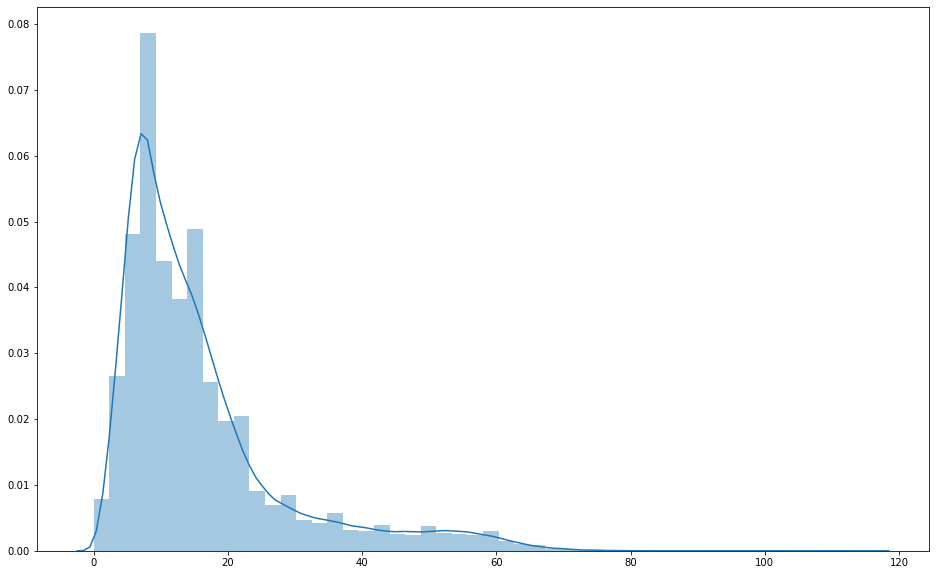

In [10]:
#문장 길이 분포 시각화 대부분의 데이터가 5~25 사이에 몰려있다. but 30~70 사이의 데이터 추이를 주목.
plt.rcParams['figure.figsize'] = (16, 10)
sns.distplot(num_tokens)
plt.show()

In [11]:
#최대 문장 길이 결정
#최대 길이를 (평균 + 2*표준편차)로 하는 경우
# max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = 60
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

pad_sequences maxlen :  60
전체 문장의 98.81744044967978%가 maxlen 설정값 이내에 포함됩니다. 


평균 + 2 * 표준편차(약 41)로 하는 경우 여기서 제외된 6.5%는 장문의 리뷰글이다. 이러한 글을 제외했을때와 반대로 너무 짧은 단편적인 감상을 제외했을때 데이터를 비교해 보아야 한다.
비교결과 유의미한 차이는 없었다.

In [12]:
#padding추가

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 60)


어순이 분명하고 감정과 평가에 대한 부분이 뒤에 후술되는 영어와 달리 한국어는 post padding과  pre padding을 직접 비교해보아야한다.
post의 accurracy는 약 75%, pre의  accuracy는 약 84%로 10%가량의 차이가 발생하였다.

In [13]:
#모델구성
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(100))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,121,217
Trainable params: 2,121,217
Non-trainable params: 0
_________________________________________________________________


In [14]:
# #모델 2

# model = keras.Sequential()
# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D(5))
# model.add(keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid')) 

In [15]:
# #모델 3

# model = keras.Sequential()
# model.add(Embedding(vocab_size, 100))
# model.add(GRU(128))
# model.add(Dense(1, activation='sigmoid'))

In [16]:
#validation set 구성

# validation set 2만건 분리
X_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 13만건
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 60)
(126182,)


In [17]:
#모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 8s 31ms/step - loss: 0.4044 - accuracy: 0.8156 - val_loss: 0.3370 - val_accuracy: 0.8529
Epoch 2/3
247/247 [==============================] - 7s 30ms/step - loss: 0.3118 - accuracy: 0.8664 - val_loss: 0.3311 - val_accuracy: 0.8575
Epoch 3/3
247/247 [==============================] - 7s 30ms/step - loss: 0.2758 - accuracy: 0.8829 - val_loss: 0.3315 - val_accuracy: 0.8611


In [18]:
#Loss, Accuracy 그래프 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


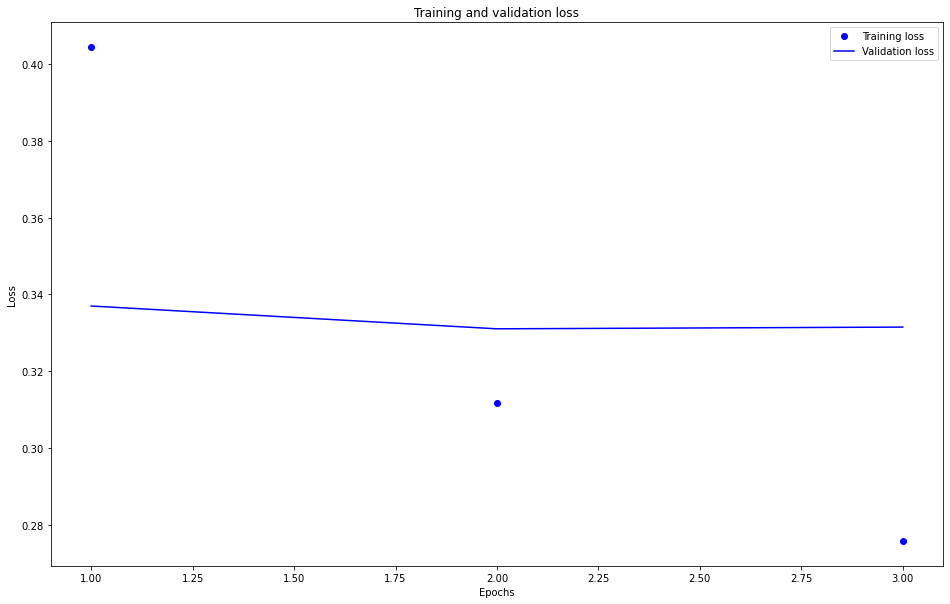

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

validation loss는 epoch 2 ~ 3까지만 감소한다.

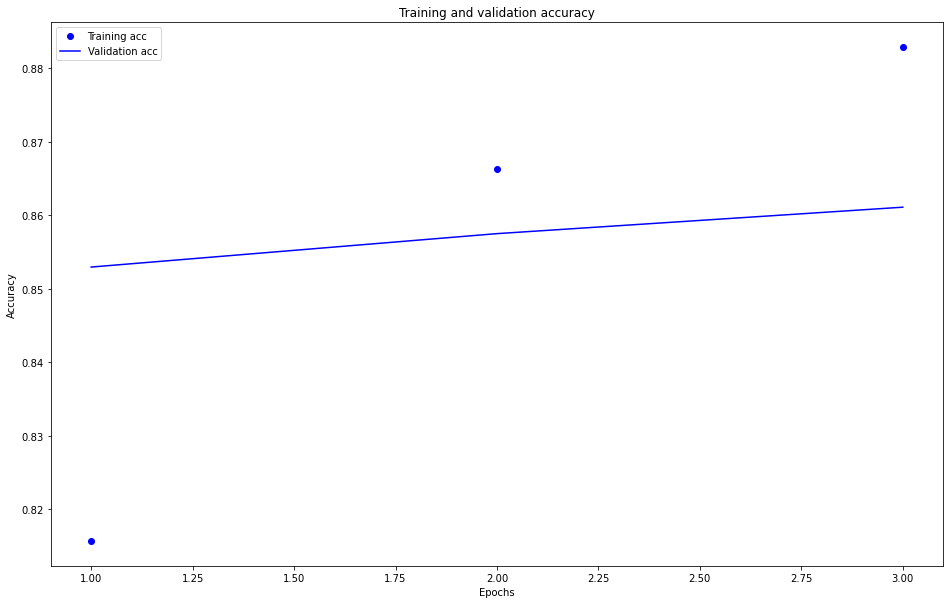

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
#test 결과
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3377 - accuracy: 0.8555
[0.33766207098960876, 0.8555241227149963]


# 테스트 결과

loss: 0.3389 - accuracy: 0.8509

In [22]:
#embedding 적용

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [23]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-6.77700490e-02, -8.38739425e-02, -3.79652008e-02, -3.64355147e-02,
        2.17163041e-02, -5.30745722e-02,  2.31982917e-02, -8.46955576e-04,
       -4.22354750e-02, -8.61195382e-04,  2.49737445e-02, -1.37824677e-02,
        1.79309887e-03,  2.87664030e-02,  7.22602978e-02, -9.87426378e-03,
       -4.06067260e-03, -2.37643048e-02,  2.26680376e-02,  2.36275103e-02,
       -1.06625613e-02, -5.92855513e-02, -2.04738546e-02, -2.62902700e-04,
        2.23990027e-02,  2.57939864e-02,  1.24485992e-01, -7.14770779e-02,
        3.47324200e-02, -3.60249467e-02, -2.89665982e-02,  9.44118481e-03,
       -3.55771072e-02, -2.40857750e-02, -5.46406433e-02,  1.94059387e-02,
       -1.14298292e-01, -1.30133554e-02,  1.35138084e-03, -4.55042943e-02,
        1.21855631e-01, -2.65660789e-02,  2.90467441e-02, -2.22842675e-02,
       -9.17262118e-03, -1.64458640e-02, -5.09486161e-02, -6.40038326e-02,
       -4.53246608e-02,  2.58280393e-02, -6.78552911e-02,  6.90557957e-02,
        6.78466484e-02,  

In [25]:
word_vectors.similar_by_word("사랑")

[('대작', 0.7856625318527222),
 ('완벽', 0.7850098609924316),
 ('수작', 0.7844745516777039),
 ('뿌듯', 0.782171368598938),
 ('습니당', 0.7799915075302124),
 ('명작', 0.7732791304588318),
 ('끌리', 0.7702724933624268),
 ('꼭', 0.7641820311546326),
 ('정점', 0.7634591460227966),
 ('올려야', 0.7626177072525024)]

큰 연관성이 보이지 않는다.

In [26]:
#한국어 Word2Vec 임베딩 활용하여 성능개선

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.vec'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
vector = word2vec['사랑']
vector

array([ 7.2242e-02, -6.9223e-02,  2.6350e-01,  2.6930e-02,  2.7465e-01,
       -5.7484e-02,  1.1657e-01, -1.0736e-01,  2.6542e-01, -1.5600e-01,
        4.8601e-01,  6.3728e-01,  5.7949e-01,  2.1420e-01, -3.2206e-02,
       -9.1503e-03,  2.0928e-01, -8.1857e-02, -2.6783e-01, -2.5602e-01,
        1.4733e-01,  4.5259e-01,  3.6965e-01,  2.4644e-01, -4.4918e-02,
       -6.7232e-02,  3.1724e-02,  3.3469e-01,  2.6623e-01, -1.1605e-01,
       -1.5161e-02,  1.0318e-01,  1.4193e-01, -7.9796e-02,  1.5111e-02,
        1.0474e-01, -2.3739e-01, -1.1473e-01, -5.4767e-02,  8.9843e-02,
        3.1133e-01,  3.2850e-01,  9.2288e-02, -1.3007e-01, -4.7345e-01,
       -4.1861e-01, -2.1817e-01, -1.6687e-02,  3.4634e-01,  1.1898e-01,
        2.5232e-01,  5.3454e-03,  9.8491e-02,  1.4123e-01,  2.8660e-02,
       -1.1567e-01,  5.5575e-01, -1.4759e-01,  2.7344e-01, -2.9719e-01,
        7.8230e-02, -2.1698e-01, -1.9905e-01,  3.0314e-01, -4.5031e-02,
        1.6996e-01, -3.5892e-01, -2.6847e-01,  1.4510e-01, -2.09

In [27]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("사랑")

[('사랑과', 0.6912475228309631),
 ('그리움', 0.6627303957939148),
 ('이별', 0.6524810791015625),
 ('그대', 0.649117112159729),
 ('연인', 0.6449648141860962),
 ('슬픔', 0.6445863246917725),
 ('외로움', 0.6422537565231323),
 ('사랑이', 0.6219197511672974),
 ('첫사랑', 0.616836667060852),
 ('애정', 0.6153576374053955)]

연관성이 뚜렷하게 보인다.

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [29]:
import keras
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=False))
model2.add(keras.layers.LSTM(100))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,121,217
Trainable params: 121,217
Non-trainable params: 2,000,000
_________________________________________________________________


In [30]:
# 학습의 진행
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/6
247/247 [==============================] - 4s 17ms/step - loss: 0.5386 - accuracy: 0.7246 - val_loss: 0.4913 - val_accuracy: 0.7595
Epoch 2/6
247/247 [==============================] - 4s 16ms/step - loss: 0.4591 - accuracy: 0.7813 - val_loss: 0.4310 - val_accuracy: 0.7997
Epoch 3/6
247/247 [==============================] - 4s 16ms/step - loss: 0.4199 - accuracy: 0.8049 - val_loss: 0.4028 - val_accuracy: 0.8137
Epoch 4/6
247/247 [==============================] - 4s 16ms/step - loss: 0.3946 - accuracy: 0.8186 - val_loss: 0.3913 - val_accuracy: 0.8194
Epoch 5/6
247/247 [==============================] - 4s 16ms/step - loss: 0.3743 - accuracy: 0.8299 - val_loss: 0.3738 - val_accuracy: 0.8302
Epoch 6/6
247/247 [==============================] - 4s 16ms/step - loss: 0.3571 - accuracy: 0.8401 - val_loss: 0.3728 - val_accuracy: 0.8295


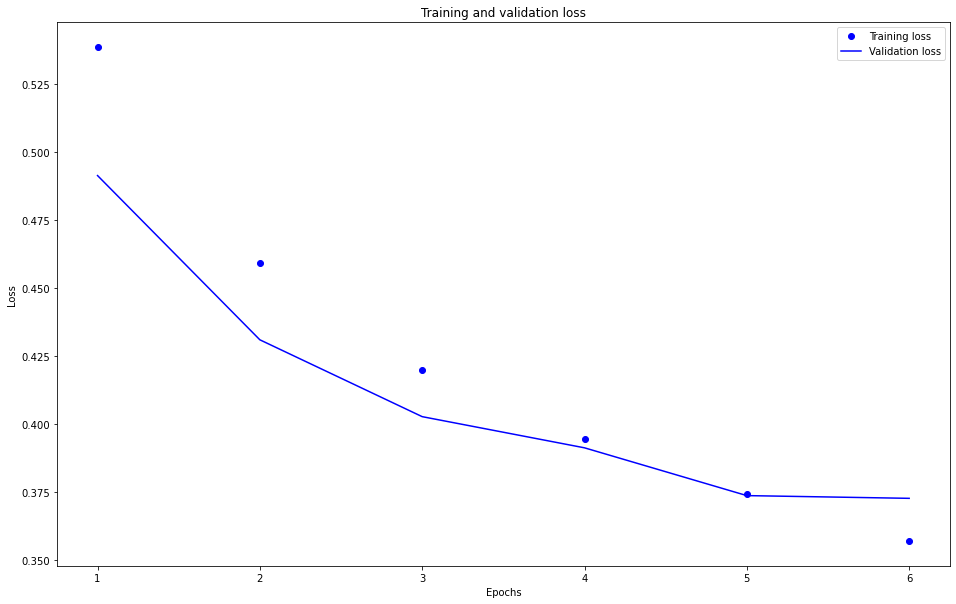

In [31]:
history_dict = history.history

plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

epoch = 6까지 감소

In [32]:
# 테스트셋을 통한 모델 평가
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3806 - accuracy: 0.8270
[0.38058724999427795, 0.8270236253738403]


# 테스트 결과 비교

loss: 0.3389 - accuracy: 0.8509

loss: 0.3753 - accuracy: 0.8312(불용어 sample 적용시)
loss: 0.3806 - accuracy: 0.8270(불용어 sample 미 적용시)

오히려 소폭 하락하였다.

# 총평

분명 embedding을 이용한 높은 연관성을 확인하였고 이를 파라미터로 활용했는데 어째서 영향이 없었는지는 알 수 없었다. 오히려 trainable 변수의 default값인 True를 False로 바꾼 영향으로 확률은 더 떨어졌다.
train loss - validation loss 그래프를 보면 일반적인 under fitting / over fitting 영역이 드러나지 않고 전형적인 over fitting의 형상의 띄었다.데이터는 적은데 설정한 모델이 이미 충분히 완성도가 높기에 이러한 현상이 벌어진 것이 아닐까 싶다.